In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az

import warnings
warnings.filterwarnings("ignore")

# Get Data

array([249, 249, 249])

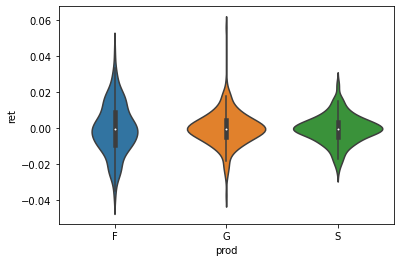

In [16]:
data = np.load("sample_data/fgs.npy" , allow_pickle = True).item()


# Combine Seperate DFs into one
combined_df = pd.DataFrame()
for k , v in data.items():
    # Create Returns and Directional Movement
    v["ret"] = v["close"].pct_change()
    v.dropna(axis = 0 , inplace = True)
    v["dir"] = v["ret"].apply(lambda x: 1 if x >= 0  else 0)
    v["prod"] = k
    combined_df = pd.concat([combined_df , v[["ret","dir","prod"]]] , axis = 0)
    
# Visualize Data
sns.violinplot(x='prod', y='ret', data=combined_df)

# Create Categories
dir_arr = combined_df['dir'].values
ret_arr = combined_df['ret'].values
idx = pd.Categorical(combined_df['prod'],
                     categories=["F","G","S"]).codes
groups = len(np.unique(idx))

# Get Samples per group
# combined_df["count"] = 1
# N_samples = combined_df.groupby("prod").sum()["count"].values
# display(N_samples)

# Bernouli Beta with Priors

In [17]:
with pm.Model() as model_h:
    mu = pm.Beta('mu', 1., 1.)
    kappa = pm.HalfNormal('kappa', 10)
    theta = pm.Beta('theta', alpha= mu * kappa , beta=(1.0 - mu) * kappa, shape = groups)
    y = pm.Bernoulli('y', p = theta[idx], observed=dir_arr)

    trace_h = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, kappa, mu]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:07<00:00, 700.84draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1211daa90>,
      dtype=object)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,0.472,0.086,0.296,0.623,0.002,0.001,3224.0,3177.0,3263.0,2540.0,1.0
kappa,12.939,6.341,1.802,24.594,0.107,0.076,3505.0,3505.0,2967.0,2347.0,1.0
theta[0],0.474,0.031,0.418,0.535,0.000,0.000,3912.0,3889.0,3914.0,3279.0,1.0
theta[1],0.473,0.031,0.417,0.532,0.001,0.000,3245.0,3225.0,3250.0,2776.0,1.0
theta[2],0.458,0.031,0.397,0.511,0.001,0.000,3398.0,3392.0,3397.0,2973.0,1.0


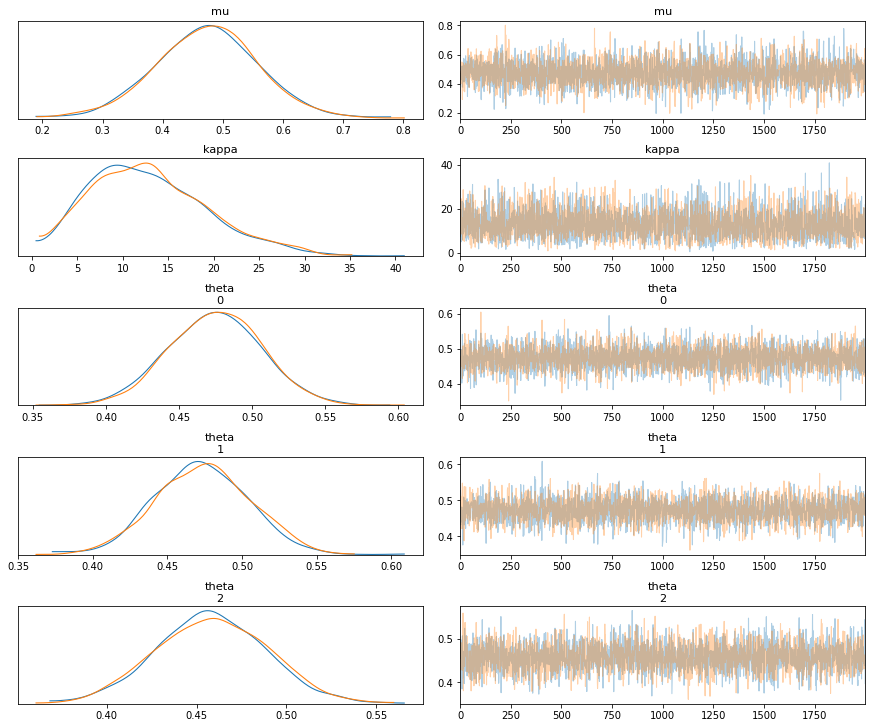

In [18]:
display(az.plot_trace(trace_h))
display(az.summary(trace_h))

# Normal with Priors

In [19]:
with pm.Model() as cs_h:
    # hyper_priors
    mu_of_mu = pm.Normal('mu_of_mu', mu=0, sd=10)
    sigma_of_mu = pm.HalfNormal('sigma_of_mu', 10)

    # priors
    mu = pm.Normal('mu', mu = mu_of_mu, sd = sigma_of_mu, shape = groups)
    sigma = pm.HalfNormal('sigma', sd=10, shape = groups)

    y = pm.Normal('y', mu=mu[idx], sd=sigma[idx], observed  = ret_arr)

    trace_cs_h = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu, sigma_of_mu, mu_of_mu]
Sampling 2 chains, 405 divergences: 100%|██████████| 3000/3000 [01:00<00:00, 49.53draws/s] 
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9501822967715325, but should be close to 0.8. Try to increase the number of tuning steps.
There were 392 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3730399004911261, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12113b690>,
      dtype=object)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_of_mu,0.000,0.014,-0.007,0.007,0.000,0.001,856.0,344.0,871.0,90.0,1.14
mu[0],-0.000,0.001,-0.002,0.001,0.000,0.000,294.0,98.0,278.0,390.0,1.10
mu[1],-0.000,0.001,-0.001,0.001,0.000,0.000,11.0,11.0,11.0,276.0,1.12
mu[2],-0.000,0.000,-0.001,0.000,0.000,0.000,133.0,55.0,203.0,775.0,1.10
sigma_of_mu,0.006,0.023,0.000,0.015,0.003,0.002,49.0,49.0,4.0,104.0,1.41
sigma[0],0.014,0.001,0.013,0.015,0.000,0.000,24.0,24.0,36.0,712.0,1.05
sigma[1],0.010,0.000,0.009,0.010,0.000,0.000,485.0,472.0,459.0,239.0,1.20
sigma[2],0.008,0.000,0.007,0.009,0.000,0.000,143.0,138.0,184.0,664.0,1.20


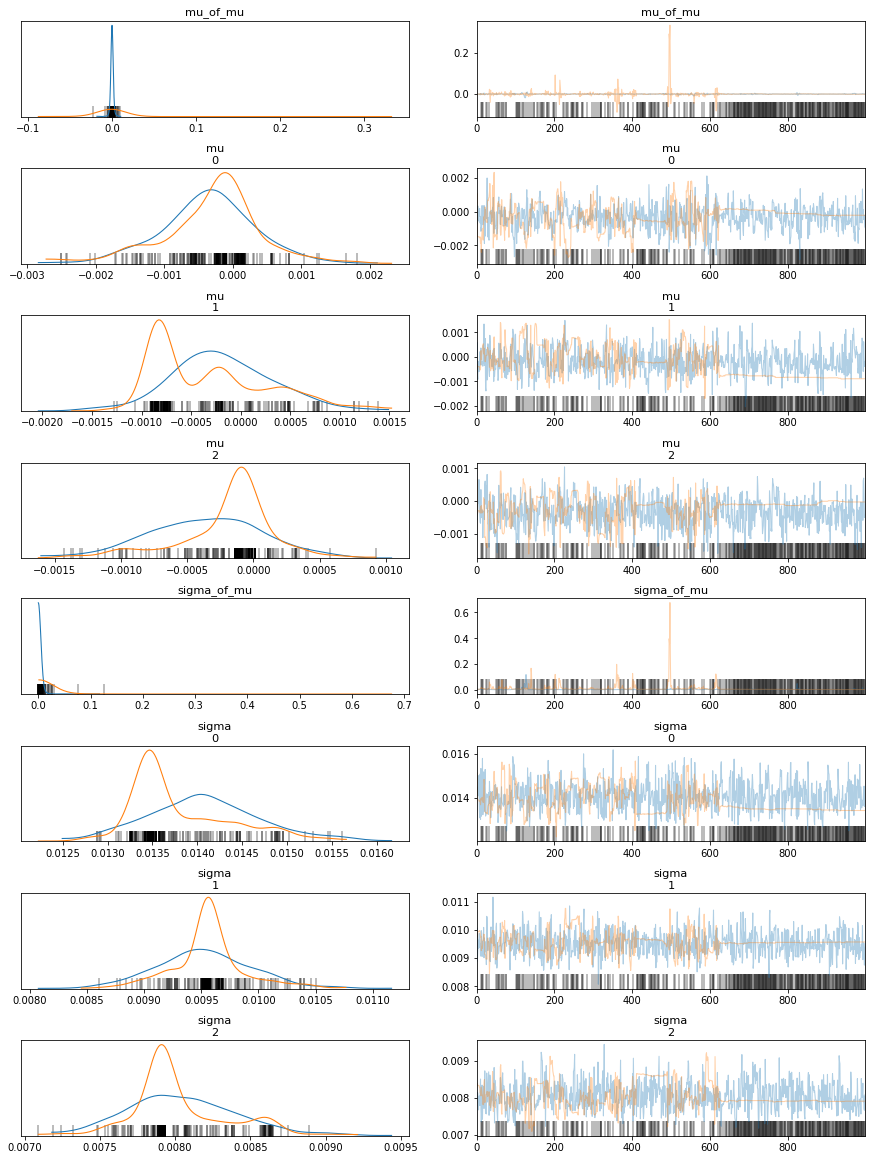

In [20]:
display(az.plot_trace(trace_cs_h))
display(az.summary(trace_cs_h))